# Experiments with a Transformer network

The implementation of the model is adapted from the Keras tutorial [Timeseries classification with a Transformer model](https://keras.io/examples/timeseries/timeseries_classification_transformer/).

Importing libraries:

In [ ]:
import os
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_tuner import HyperModel, GridSearch
from utils import get_clf_report_dfs, plot_confusion_matrix, get_trials_df

Defining constants:

In [2]:
RANDOM_SEED=42
MODEL_NAME="transformer"
RESULTS_DIR=f"./results/{MODEL_NAME}"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

Defining the network architecture:

In [4]:
class TransformerHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = tf.keras.layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def build(self, hp):
        head_size = hp.Choice("head_size", [64])
        num_heads = hp.Choice("num_heads", [2])
        ff_dim = hp.Choice("ff_dim", [64])
        num_blocks = hp.Choice("num_transformer_blocks", [1])
        mlp_units = hp.Choice("mlp_units", [64])
        dropout = hp.Choice("dropout", [0.0, 0.3])
        learning_rate = hp.Choice("learning_rate", [1e-3, 1e-4])

        inputs = keras.Input(shape=self.input_shape)
        x = inputs
        for _ in range(num_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dense(mlp_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        outputs = tf.keras.layers.Dense(self.num_classes, activation="softmax")(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )
        return model

Displaying the hyperparameters space:

In [5]:
tuner = GridSearch(
    TransformerHyperModel(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train))),
    objective='val_sparse_categorical_accuracy',
    seed=RANDOM_SEED,
    overwrite=True,
    directory=RESULTS_DIR,
    project_name='transformer_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
head_size (Choice)
{'default': 64, 'conditions': [], 'values': [64], 'ordered': True}
num_heads (Choice)
{'default': 2, 'conditions': [], 'values': [2], 'ordered': True}
ff_dim (Choice)
{'default': 64, 'conditions': [], 'values': [64], 'ordered': True}
num_transformer_blocks (Choice)
{'default': 1, 'conditions': [], 'values': [1], 'ordered': True}
mlp_units (Choice)
{'default': 64, 'conditions': [], 'values': [64], 'ordered': True}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


Running the grid search:

In [6]:
num_epochs = 500
batch_size = 16
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)
tuner.search(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)

Trial 4 Complete [00h 03m 12s]
val_sparse_categorical_accuracy: 0.5375000238418579

Best val_sparse_categorical_accuracy So Far: 0.637499988079071
Total elapsed time: 00h 11m 39s


Displaying grid search results:

In [7]:
get_trials_df(tuner, 'val_sparse_categorical_accuracy')

,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout,learning_rate,val_sparse_categorical_accuracy
3,64,2,64,1,64,0.300000,0.000100,0.537500
1,64,2,64,1,64,0.000000,0.000100,0.612500
2,64,2,64,1,64,0.300000,0.001000,0.612500
0,64,2,64,1,64,0.000000,0.001000,0.637500


Getting and displaying the best model:

In [8]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 4)    │      2,436 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 150, 4)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 4)    │          8 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 150, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 150, 64)   │        320 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 150, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 150, 4)    │        260 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 4)    │          8 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 150, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 17)        │      1,105 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,457 (17.41 KB)

 Trainable params: 4,457 (17.41 KB)

 Non-trainable params: 0 (0.00 B)

Re-training to inspect learning curves:

In [9]:
history = best_model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
best_model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.7835 - sparse_categorical_accuracy: 0.1165 - val_loss: 2.5469 - val_sparse_categorical_accuracy: 0.1250 - learning_rate: 0.0010
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4606 - sparse_categorical_accuracy: 0.1541 - val_loss: 2.3902 - val_sparse_categorical_accuracy: 0.2625 - learning_rate: 0.0010
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2738 - sparse_categorical_accuracy: 0.2140 - val_loss: 2.1764 - val_sparse_categorical_accuracy: 0.3125 - learning_rate: 0.0010
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.0925 - sparse_categorical_accuracy: 0.2527 - val_loss: 2.0098 - val_sparse_categorical_accuracy: 0.3375 - learning_rate: 0.0010
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.0035 - sparse_categorical_accuracy: 0.2486 - val_loss: 1.8852 - val_sparse_categorical_accuracy: 0.3500 - learning_rate: 0.0010
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/ste

Visualizing learning curves:

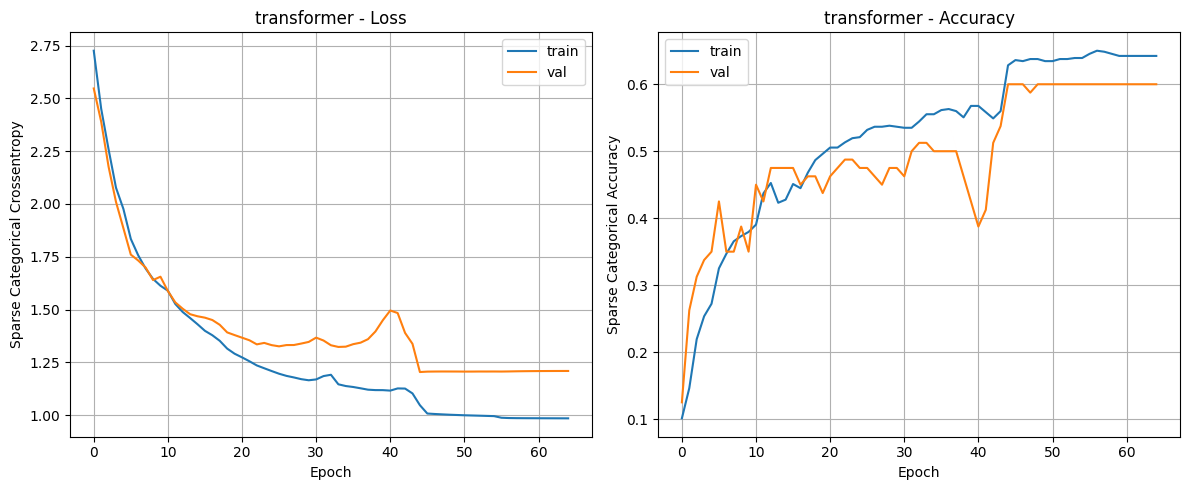

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

Displaying model loss and accuracy:

In [11]:
train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Val", "Test"],
    "Loss": [train_loss, val_loss, test_loss],
    "Accuracy": [train_accuracy, val_accuracy, test_accuracy]
}).set_index("Dataset")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9715 - sparse_categorical_accuracy: 0.6485
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2121 - sparse_categorical_accuracy: 0.6242
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.6179


,Loss,Accuracy
Dataset,,
Train,1.003378,0.642302
Val,1.203960,0.600000
Test,1.151991,0.641975


Displaying model performance on the test set:

In [ ]:
start_time = time.time()
y_pred_proba = best_model.predict(X_test)
inference_time = time.time() - start_time

with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_inference_time.json"), 'w') as f:
    json.dump({"inference time [s]": inference_time}, f)

y_pred = np.argmax(y_pred_proba, axis=1)
np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.641975,0.611932,0.616041,0.65915,0.668024,0.642157,0.641975


In [13]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.666667,0.500000,0.571429,4.000000
bigball,0.333333,0.200000,0.250000,5.000000
box,1.000000,1.000000,1.000000,4.000000
button,0.428571,0.500000,0.461538,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,0.400000,0.500000,0.444444,4.000000
cylinder,0.750000,0.600000,0.666667,5.000000
empty,0.555556,1.000000,0.714286,5.000000
jenga,0.375000,0.750000,0.500000,4.000000
labello,1.000000,0.600000,0.750000,5.000000


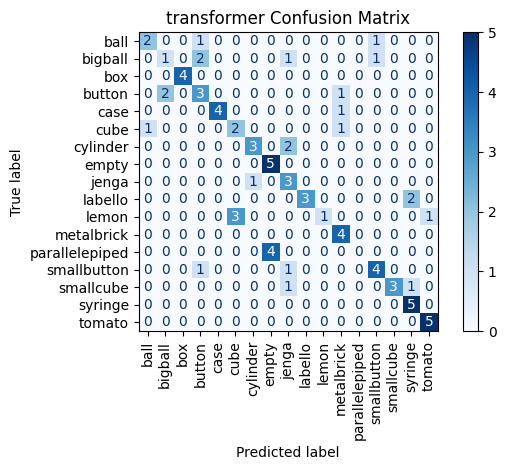

In [14]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)